## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# load data 
# ----------
congress_tweets = pd.read_csv("116th Congressional Tweets and Demographics.csv")

# randomly select 1000 rows to analyze
tweet_subsample = congress_tweets.sample(n=10000, random_state=42)
tweet_subsample.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670"
175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892"
64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843"
553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [3]:
pd.set_option('display.max_colwidth', None)
print (tweet_subsample['text'].head(1))

908961    RT @RepKClark 22 million Americans filed for unemployment in the last 4 weeks. We need to find innovative solutions and to act fast. That's why I support the #PaycheckGuaranteeAct, which will cover 100% of wages for workers earning up to $100k and will ensure workers keep their #healthcare. https://twitter.com/politico/status/1250764214433611784 QT @politico BREAKING: 5.2 million Americans applied for unemployment last week. In four weeks alone, that’s more than 22 million people seeking jobless benefits. https://www.politico.com/news/2020/04/16/coronavirus-unemployment-claims-numbers-190026
Name: text, dtype: object


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [4]:
#Remove links first

import re

# Define a function for removing links
def remove_links(text):
    return re.sub(r'http\S+', '', text)

# Apply the function to all texts 
tweet_subsample['tweet_nolink'] = tweet_subsample['text'].apply(remove_links)

# Example output
print (tweet_subsample['tweet_nolink'].head(1))

908961    RT @RepKClark 22 million Americans filed for unemployment in the last 4 weeks. We need to find innovative solutions and to act fast. That's why I support the #PaycheckGuaranteeAct, which will cover 100% of wages for workers earning up to $100k and will ensure workers keep their #healthcare.  QT @politico BREAKING: 5.2 million Americans applied for unemployment last week. In four weeks alone, that’s more than 22 million people seeking jobless benefits. 
Name: tweet_nolink, dtype: object


In [5]:
# Tokenize texts

# Define the function for tokenizing texts
nlp = en_core_web_sm.load()
def tokenize_text(text):
    doc = nlp(text)
    return [token.text for token in doc]

# Apply the function to all texts 
tweet_subsample['tokenized_text'] = tweet_subsample['tweet_nolink'].apply(tokenize_text)

# Example tokenized words
first_row_tokenized= tweet_subsample['tokenized_text'].iloc[0]
first_10_tokens = first_row_tokenized[:10]
list(first_10_tokens)

['RT',
 '@RepKClark',
 '22',
 'million',
 'Americans',
 'filed',
 'for',
 'unemployment',
 'in',
 'the']

In [6]:
#Remove flags for retweeting 

#define a function for removing flag for retweeting 
def clean_text(tokenized_text):
    cleaned_tokens = []
    for token in tokenized_text:
        if not token.startswith('@') and token != "RT":
            cleaned_tokens.append(token)
    return cleaned_tokens

#apply the function to reduced texts
tweet_subsample['no_flag'] = tweet_subsample['tokenized_text'].apply(clean_text)


#example output
first_row_no_flag = tweet_subsample['no_flag'].iloc[0]
first_10_no_flag= first_row_no_flag[:10]
list(first_10_no_flag)

['22',
 'million',
 'Americans',
 'filed',
 'for',
 'unemployment',
 'in',
 'the',
 'last',
 '4']

In [7]:
# Remove stop words and punctuation from tokens

# Define the function for removing stop words and punctuation from tokens
def rem_punc_stop(tokens):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    cleaned_tokens = []
    for token in tokens:
        cleaned_token = ''.join([ch for ch in token if ch not in punc])
        if cleaned_token and cleaned_token.lower() not in stop_words:
            cleaned_tokens.append(cleaned_token)
    return cleaned_tokens

# Applying the function to tokenized texts
tweet_subsample['token_reduced'] = tweet_subsample['no_flag'].apply(rem_punc_stop)

# Example output
first_row_token_reduced = tweet_subsample['token_reduced'].iloc[0]
first_10_reduced = first_row_token_reduced[:10]
list(first_10_reduced)

['22',
 'million',
 'Americans',
 'filed',
 'unemployment',
 '4',
 'weeks',
 'need',
 'find',
 'innovative']

In [8]:
# Save data for convenience
tweet_subsample.to_csv('tweet_subsample_cleaned.csv', index=False)

In [9]:
preprocessed_tweets = pd.read_csv("tweet_subsample_cleaned.csv")
preprocessed_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tweet_nolink,tokenized_text,no_flag,token_reduced
0,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,"RT @RepKClark 22 million Americans filed for unemployment in the last 4 weeks. We need to find innovative solutions and to act fast. That's why I support the #PaycheckGuaranteeAct, which will cover 100% of wages for workers earning up to $100k and will ensure workers keep their #healthcare. https://twitter.com/politico/status/1250764214433611784 QT @politico BREAKING: 5.2 million Americans applied for unemployment last week. In four weeks alone, that’s more than 22 million people seeking jobless benefits. https://www.politico.com/news/2020/04/16/coronavirus-unemployment-claims-numbers-190026",Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670","RT @RepKClark 22 million Americans filed for unemployment in the last 4 weeks. We need to find innovative solutions and to act fast. That's why I support the #PaycheckGuaranteeAct, which will cover 100% of wages for workers earning up to $100k and will ensure workers keep their #healthcare. QT @politico BREAKING: 5.2 million Americans applied for unemployment last week. In four weeks alone, that’s more than 22 million people seeking jobless benefits.","['RT', '@RepKClark', '22', 'million', 'Americans', 'filed', 'for', 'unemployment', 'in', 'the', 'last', '4', 'weeks', '.', 'We', 'need', 'to', 'find', 'innovative', 'solutions', 'and', 'to', 'act', 'fast', '.', 'That', ""'s"", 'why', 'I', 'support', 'the', '#', 'PaycheckGuaranteeAct', ',', 'which', 'will', 'cover', '100', '%', 'of', 'wages', 'for', 'workers', 'earning', 'up', 'to', '$', '100k', 'and', 'will', 'ensure', 'workers', 'keep', 'their', '#', 'healthcare', '.', ' ', 'QT', '@politico', 'BREAKING', ':', '5.2', 'million', 'Americans', 'applied', 'for', 'unemployment', 'last', 'week', '.', 'In', 'four', 'weeks', 'alone', ',', 'that', '’s', 'more', 'than', '22', 'million', 'people', 'seeking', 'jobless', 'benefits', '.']","['22', 'million', 'Americans', 'filed', 'for', 'unemployment', 'in', 'the', 'last', '4', 'weeks', '.', 'We', 'need', 'to', 'find', 'innovative', 'solutions', 'and', 'to', 'act', 'fast', '.', 'That', ""'s"", 'why', 'I', 'support', 'the', '#', 'PaycheckGuaranteeAct', ',', 'which', 'will', 'cover', '100', '%', 'of', 'wages', 'for', 'workers', 'earning', 'up', 'to', '$', '100k', 'and', 'will', 'ensure', 'workers', 'keep', 'their', '#', 'healthcare', '.', ' ', 'QT', 'BREAKING', ':', '5.2', 'million', 'Americans', 'applied', 'for', 'unemployment', 'last', 'week', '.', 'In', 'four', 'weeks', 'alone', ',', 'that', '’s', 'more', 'than', '22', 'million', 'people', 'seeking', 'jobless', 'benefits', '.']","['22', 'million', 'Americans', 'filed', 'unemployment', '4', 'weeks', 'need', 'find', 'innovative', 'solutions', 'act', 'fast', 's', 'support', 'PaycheckGuaranteeAct', 'cover', '100', 'wages', 'workers', 'earning', '100k', 'ensure', 'workers', 'healthcare', ' ', 'QT', 'BREAKING', '52', 'million', 'Americans', 'applied', 'unemployment', 'week', 'weeks', '22', 'million', 'people', 'seeking', 'jobless', 'benefits']"
1,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum on the #GOPTaxLaw http://pbs.twimg.com/media/Dz0DJyKWsAAT3FZ.jpg http://pbs.twimg.com/media/Dz0DJyKXgAAyc6N.jpg http://pbs.twimg.com/media/Dz0DJyLWkAUzD4L.jpg,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892",Thanks to all who came out to tonight’s forum on the #GOPTaxLaw,"['Thanks', 'to', 'all', 'who', 'came', 'out', 'to', 'tonight', '’s', 'forum', 'on', 'the', '#', 'GOPTaxLaw', ' ']","['Thanks', 'to', 'all', 'who', 'came', 'out', 'to', 'tonight', '’s', 'forum', 'on', 'the', '#', 'GOPTaxLaw', ' ']","['Thank

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1 - Word Cloud

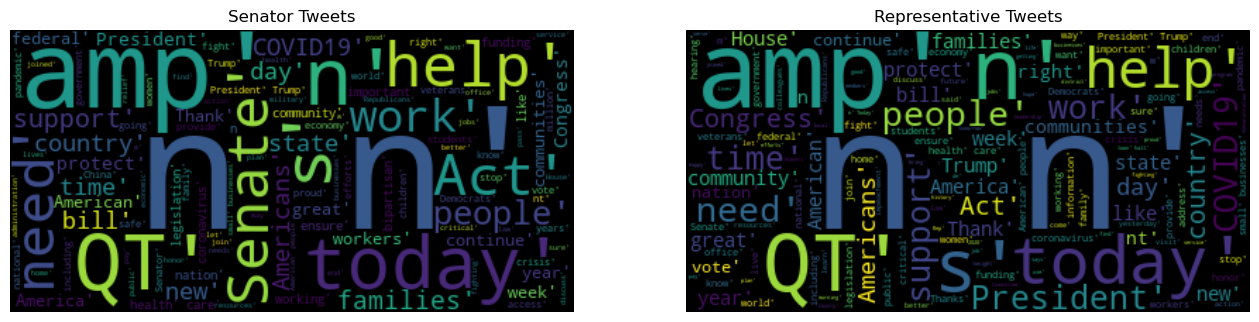

In [10]:
from wordcloud import WordCloud

tweet_cleaned = pd.read_csv('tweet_subsample_cleaned.csv')

#Filter tweets for senators and representatives 
senator_tweets = tweet_cleaned[tweet_cleaned['position'] == 'Sen']
representative_tweets = tweet_cleaned[tweet_cleaned['position'] == 'Rep']

senator_text = ' '.join(senator_tweets['token_reduced'])
rep_text=' '.join(representative_tweets['token_reduced'])

senator_wordcloud = WordCloud(random_state=40).generate(senator_text) 
rep_wordcloud = WordCloud(random_state=40).generate(rep_text) 

#plot
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(senator_wordcloud, interpolation='bilinear')
plt.title('Senator Tweets')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rep_wordcloud, interpolation='bilinear')
plt.title('Representative Tweets')
plt.axis('off')

plt.show()                  

### EDA 2 - ScatterText

In [11]:
import scattertext as st

text = ' '.join(tweet_cleaned['token_reduced'])

corpus = st.CorpusFromPandas(tweet_cleaned,
                             category_col='position',  
                             text_col='text',  
                             nlp=nlp).build()

html = st.produce_scattertext_explorer(corpus,
                                       category='Rep',  
                                       category_name='Representative',
                                       not_category_name='Senator',
                                       minimum_term_frequency=10,
                                       width_in_pixels=1000,
                                       metadata=tweet_cleaned['name_wikipedia'])  

# Saving the visualization to an HTML file
open("tweets.html", 'wb').write(html.encode('utf-8'))

5237869

## Sentiment Analysis 

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

/var/folders/bk/f254y33d5wx5ffm981thyc6r0000gn/T/ipykernel_84430/689867132.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bernie_tweets['polarity'], label='Bernie Sanders', shade=True)
/var/folders/bk/f254y33d5wx5ffm981thyc6r0000gn/T/ipykernel_84430/689867132.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mcconnell_tweets['polarity'], label='Mitch McConnell', shade=True)


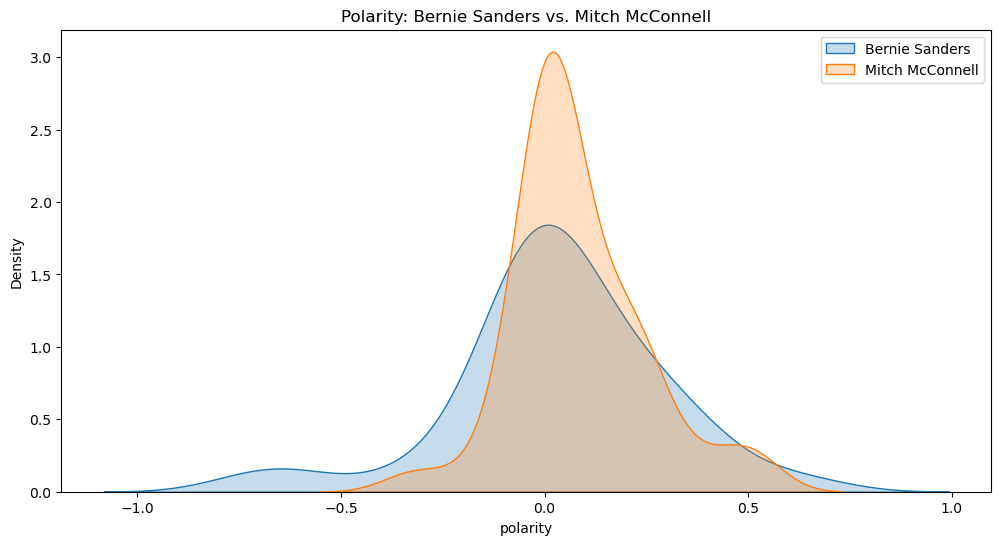

/var/folders/bk/f254y33d5wx5ffm981thyc6r0000gn/T/ipykernel_84430/689867132.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bernie_tweets['subjectivity'], label='Bernie Sanders', shade=True)
/var/folders/bk/f254y33d5wx5ffm981thyc6r0000gn/T/ipykernel_84430/689867132.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mcconnell_tweets['subjectivity'], label='Mitch McConnell', shade=True)


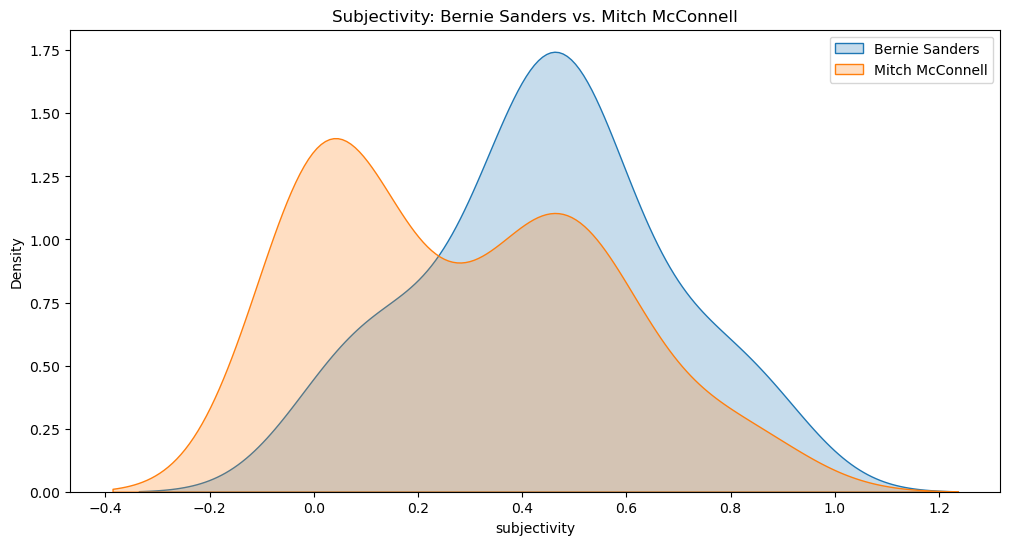

In [12]:
#Generate subjectivity and sentiment scores
tweet_cleaned['polarity'] = tweet_cleaned['text'].map(lambda text: TextBlob(text).sentiment.polarity)
tweet_cleaned['subjectivity'] = tweet_cleaned['text'].map(lambda text: TextBlob(text).sentiment.subjectivity)

### Here, Bernie Sanders is usually considered liberal and Mitch McConnell considered conservative
bernie_tweets = tweet_cleaned[tweet_cleaned['name_wikipedia'] == 'Bernie Sanders']
mcconnell_tweets = tweet_cleaned[tweet_cleaned['name_wikipedia'] == 'Mitch McConnell']

# Plot sentiment distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(bernie_tweets['polarity'], label='Bernie Sanders', shade=True)
sns.kdeplot(mcconnell_tweets['polarity'], label='Mitch McConnell', shade=True)
plt.title('Polarity: Bernie Sanders vs. Mitch McConnell')
plt.xlabel('polarity')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(bernie_tweets['subjectivity'], label='Bernie Sanders', shade=True)
sns.kdeplot(mcconnell_tweets['subjectivity'], label='Mitch McConnell', shade=True)
plt.title('Subjectivity: Bernie Sanders vs. Mitch McConnell')
plt.xlabel('subjectivity')
plt.legend()
plt.show()


These scores, while limited in scale, do match my thoughts: in my understanding, liberals tend to express more emotions, especially negative emotions than conservatives

/var/folders/bk/f254y33d5wx5ffm981thyc6r0000gn/T/ipykernel_84430/2788179922.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(democrat_tweets['polarity'], label='Democrats', shade=True)
/var/folders/bk/f254y33d5wx5ffm981thyc6r0000gn/T/ipykernel_84430/2788179922.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(republican_tweets['polarity'], label='Republicans', shade=True)


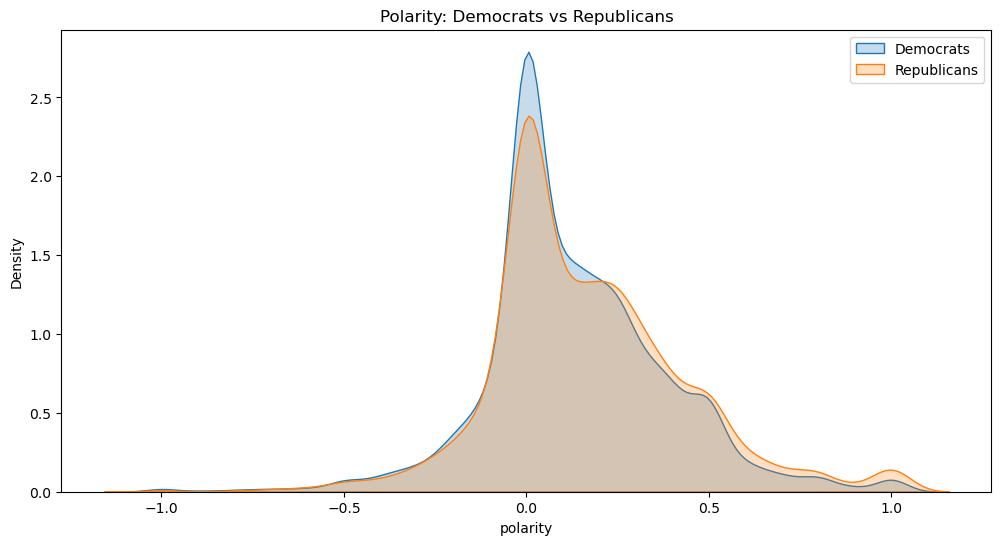

/var/folders/bk/f254y33d5wx5ffm981thyc6r0000gn/T/ipykernel_84430/2788179922.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(democrat_tweets['subjectivity'], label='Democrats', shade=True)
/var/folders/bk/f254y33d5wx5ffm981thyc6r0000gn/T/ipykernel_84430/2788179922.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(republican_tweets['subjectivity'], label='Republicans', shade=True)


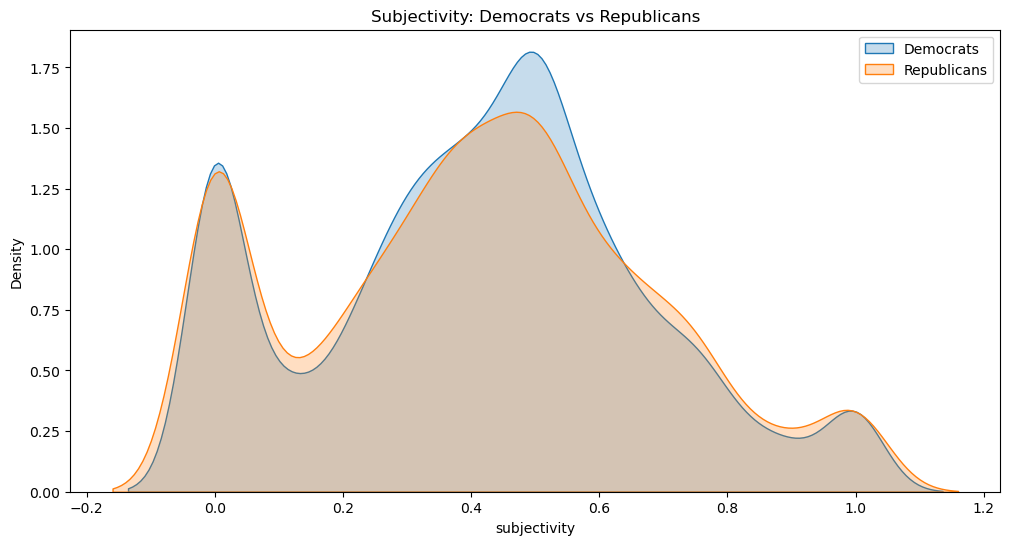

In [13]:
### Democrats vs. Republicans
democrat_tweets = tweet_cleaned[tweet_cleaned['party'] == 'Democrat']
republican_tweets = tweet_cleaned[tweet_cleaned['party'] == 'Republican']

plt.figure(figsize=(12, 6))
sns.kdeplot(democrat_tweets['polarity'], label='Democrats', shade=True)
sns.kdeplot(republican_tweets['polarity'], label='Republicans', shade=True)
plt.title('Polarity: Democrats vs Republicans')
plt.xlabel('polarity')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(democrat_tweets['subjectivity'], label='Democrats', shade=True)
sns.kdeplot(republican_tweets['subjectivity'], label='Republicans', shade=True)
plt.title('Subjectivity: Democrats vs Republicans')
plt.xlabel('subjectivity')
plt.legend()
plt.show()

/var/folders/bk/f254y33d5wx5ffm981thyc6r0000gn/T/ipykernel_84430/1831172849.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(senator_tweets['polarity'], label='Senators', shade=True)
/var/folders/bk/f254y33d5wx5ffm981thyc6r0000gn/T/ipykernel_84430/1831172849.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rep_tweets['polarity'], label='Representatives', shade=True)


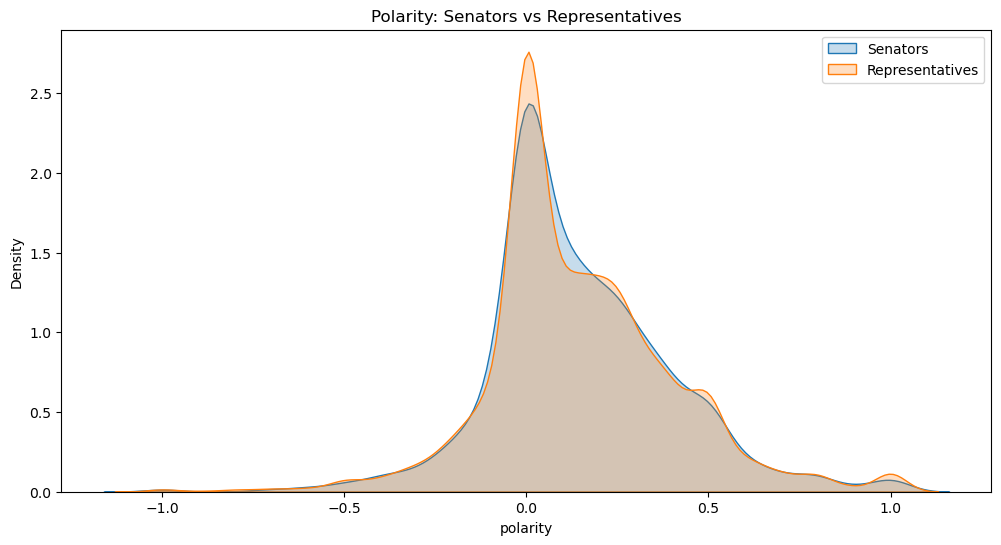

/var/folders/bk/f254y33d5wx5ffm981thyc6r0000gn/T/ipykernel_84430/1831172849.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(senator_tweets['subjectivity'], label='Senators', shade=True)
/var/folders/bk/f254y33d5wx5ffm981thyc6r0000gn/T/ipykernel_84430/1831172849.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rep_tweets['subjectivity'], label='Representatives', shade=True)


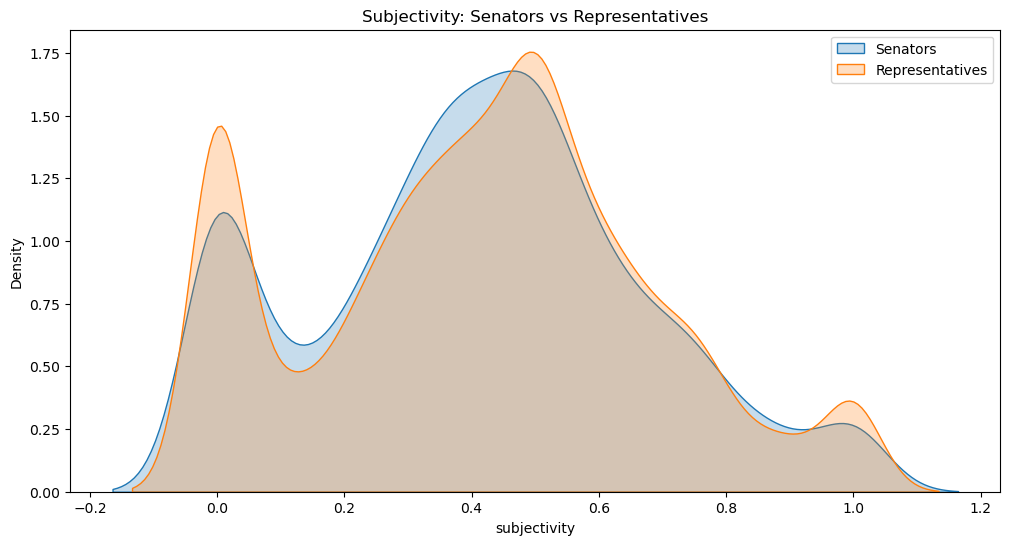

In [14]:
### Senators vs. Representatives
senator_tweets = tweet_cleaned[tweet_cleaned['position'] == 'Sen']
rep_tweets = tweet_cleaned[tweet_cleaned['position'] == 'Rep']

# Plot sentiment distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(senator_tweets['polarity'], label='Senators', shade=True)
sns.kdeplot(rep_tweets['polarity'], label='Representatives', shade=True)
plt.title('Polarity: Senators vs Representatives')
plt.xlabel('polarity')
plt.legend()
plt.show()

# Plot sentiment distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(senator_tweets['subjectivity'], label='Senators', shade=True)
sns.kdeplot(rep_tweets['subjectivity'], label='Representatives', shade=True)
plt.title('Subjectivity: Senators vs Representatives')
plt.xlabel('subjectivity')
plt.legend()
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [15]:
# Sentiment scores
tweet_cleaned['polarity'] = tweet_cleaned['token_reduced'].apply(lambda text: TextBlob(text).sentiment.polarity)
polarity_df = pd.DataFrame(tweet_cleaned['polarity'], columns=['polarity'])

### Bag-of-words or Tf-idf

In [16]:
# Tf-idf
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(tweet_cleaned['token_reduced'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())

   000  007  010  0127  013   02  0200  0211   03  0548  ...  𝗽𝗲𝗼𝗽𝗹𝗲  \
0  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  ...     0.0   
1  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  ...     0.0   
2  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  ...     0.0   
3  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  ...     0.0   
4  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  ...     0.0   

   𝗽𝗿𝗶𝗼𝗿𝗶𝘁𝘆  𝘀𝗮𝗳𝗲𝘁𝘆  𝘁𝗵𝗮𝘁  𝘁𝗵𝗲  𝘄𝗮𝗹𝗸𝗶𝗻𝗴  𝘆𝗼𝘂  𝘮𝘰𝘳𝘦  𝙏𝙀𝘼𝙈  𝙩𝙤𝙙𝙖𝙮  
0       0.0     0.0   0.0  0.0      0.0  0.0   0.0   0.0    0.0  
1       0.0     0.0   0.0  0.0      0.0  0.0   0.0   0.0    0.0  
2       0.0     0.0   0.0  0.0      0.0  0.0   0.0   0.0    0.0  
3       0.0     0.0   0.0  0.0      0.0  0.0   0.0   0.0    0.0  
4       0.0     0.0   0.0  0.0      0.0  0.0   0.0   0.0    0.0  

[5 rows x 21260 columns]


### Word Embedding

In [17]:
# Load Word2Vec model from Google

model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True)

In [18]:
# Function to average word embeddings for a document
def document_vector(model, doc):
    doc = [word for word in doc if word in model.key_to_index]
    if len(doc) > 0:
        return numpy.mean(model.__getitem__(doc), axis=0)
    else:
        return numpy.zeros(model.vector_size)

In [19]:
empty_list_embeddings_means = []

for doc in tweet_cleaned['token_reduced']:  
    empty_list_embeddings_means.append(document_vector(model, doc))

doc_average_embeddings = numpy.array(empty_list_embeddings_means)

print(doc_average_embeddings)

doc_average_embeddings.shape

[[-0.13200204  0.0918856   0.00795208 ... -0.00693251 -0.1058239
   0.1467195 ]
 [-0.20172797  0.10925971  0.02109104 ...  0.0151322  -0.11615216
   0.10340033]
 [-0.17364711  0.10572384 -0.0098084  ... -0.00537944 -0.09307056
   0.13255011]
 ...
 [-0.16412501  0.11443204 -0.01691007 ... -0.01610144 -0.10405792
   0.14319736]
 [-0.16416238  0.1099909  -0.0020745  ... -0.01063468 -0.09316462
   0.15087371]
 [-0.17597254  0.13032328  0.00456505 ... -0.01625675 -0.12856808
   0.13264765]]


(10000, 300)

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [20]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def train_and_evaluate(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))
    return model

# define x and y
y_political_party = tweet_cleaned['party']  
y_role = tweet_cleaned['position'] 
x_engineered_features = tweet_cleaned['polarity'].values.reshape(-1, 1)
x_frequency =tfidf_df.values
x_embedding_features = doc_average_embeddings  

# Models for position
print("Role prediction with engineered features:")
train_and_evaluate(x_engineered_features, y_role)

print("Role prediction with frequency-based features:")
train_and_evaluate(x_frequency, y_role)

print("Role prediction with embedding features:")
train_and_evaluate(x_embedding_features, y_role)


# Models for political party
print("Political affiliation prediction with engineered features:")
train_and_evaluate(x_engineered_features, y_political_party)

print("Political affiliation prediction with frequency-based features:")
train_and_evaluate(x_frequency, y_political_party)

print("Political affiliation prediction with embedding features:")
train_and_evaluate(x_embedding_features, y_political_party)


Role prediction with engineered features:
Accuracy: 0.7675
              precision    recall  f1-score   support

         Rep       0.77      1.00      0.87      1535
         Sen       0.00      0.00      0.00       465

    accuracy                           0.77      2000
   macro avg       0.38      0.50      0.43      2000
weighted avg       0.59      0.77      0.67      2000

Role prediction with frequency-based features:


/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.781
              precision    recall  f1-score   support

         Rep       0.78      0.99      0.87      1535
         Sen       0.75      0.09      0.15       465

    accuracy                           0.78      2000
   macro avg       0.77      0.54      0.51      2000
weighted avg       0.78      0.78      0.71      2000

Role prediction with embedding features:
Accuracy: 0.7675


/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xingqiye/ana

              precision    recall  f1-score   support

         Rep       0.77      1.00      0.87      1535
         Sen       0.00      0.00      0.00       465

    accuracy                           0.77      2000
   macro avg       0.38      0.50      0.43      2000
weighted avg       0.59      0.77      0.67      2000

Political affiliation prediction with engineered features:
Accuracy: 0.6435
              precision    recall  f1-score   support

    Democrat       0.64      1.00      0.78      1287
 Independent       0.00      0.00      0.00        12
  Republican       0.00      0.00      0.00       701

    accuracy                           0.64      2000
   macro avg       0.21      0.33      0.26      2000
weighted avg       0.41      0.64      0.50      2000

Political affiliation prediction with frequency-based features:
Accuracy: 0.7345
              precision    recall  f1-score   support

    Democrat       0.74      0.91      0.82      1287
 Independent       0.00   

/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.642
              precision    recall  f1-score   support

    Democrat       0.64      0.99      0.78      1287
 Independent       0.00      0.00      0.00        12
  Republican       0.44      0.02      0.03       701

    accuracy                           0.64      2000
   macro avg       0.36      0.33      0.27      2000
weighted avg       0.57      0.64      0.51      2000



/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression(max_iter=1000, random_state=42)

### Two Combined Models

In [22]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])

from sklearn.preprocessing import OneHotEncoder
from datetime import datetime

#define non-text features 
# numerical features
datetime_variables = ['joined_congress_date', 'birthday']
for var in datetime_variables:
    tweet_cleaned[var] = pd.to_datetime(tweet_cleaned[var], utc=True) 
    tweet_cleaned[var] = tweet_cleaned[var].dt.tz_localize(None)
tweet_cleaned['age'] = datetime.now().year - pd.to_datetime(tweet_cleaned['birthday']).dt.year
tweet_cleaned['joined_congress_year'] = pd.to_datetime(tweet_cleaned['joined_congress_date']).dt.year
# categorial features 
encoder = OneHotEncoder(sparse=False)
encoded_categorical = encoder.fit_transform(tweet_cleaned[['gender', 'state']])
# non-text features
numerical_features = tweet_cleaned[['joined_congress_year', 'age']].values
x_non_text_features = numpy.hstack((numerical_features, encoded_categorical))

# combined features
x_combined_features = numpy.hstack((x_frequency, x_non_text_features))

# define y
y_party = tweet_cleaned['party'].values  
y_role = tweet_cleaned['position'].values  

#comparison: 
# using just the non-text features 
print("non-text features:")
model_non_text_party = train_and_evaluate(x_non_text_features, y_party)

# using combined features 
print("combined features:")
model_combined_role = train_and_evaluate(x_combined_features, y_party)

/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


non-text features:


/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are i

Accuracy: 0.851
              precision    recall  f1-score   support

    Democrat       0.88      0.88      0.88      1287
 Independent       0.00      0.00      0.00        12
  Republican       0.79      0.80      0.80       701

    accuracy                           0.85      2000
   macro avg       0.56      0.56      0.56      2000
weighted avg       0.85      0.85      0.85      2000

combined features:
Accuracy: 0.8585
              precision    recall  f1-score   support

    Democrat       0.89      0.89      0.89      1287
 Independent       0.00      0.00      0.00        12
  Republican       0.80      0.82      0.81       701

    accuracy                           0.86      2000
   macro avg       0.56      0.57      0.57      2000
weighted avg       0.85      0.86      0.86      2000



/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xingqiye/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are i

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Answer**: Different corpus could have different characteritics. For instance, a journal paper in medicine contains many medical jargons and models that work the best on it might not work as well on a novel; twitter test data might contain more mispellings than news article; a book has different strutcure from an academic paper. Therefore, in order to handle thses varying features more efficiently and acheives greater accuracy when dealing with a specific text dataset, we need to customize the model to a particular corpus. 

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Answer**: In general, I did not notice significant differences across both groups. The distribution of polarity and subjectivity seems quite similar for Democrats and Republicans, as well as for Senators and Representatives. However, there is a significant difference between the sentiments of Bernie Sanders vs. Mitch McConnell, who might represent the extreme cases of each party. 

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Answer**:Validating exploratory and unsupervised learning approaches with a supervised learning algorithm is valuable because it offers quantitative measures for how well the patterns we identified through unsupervised method match the actual labels of interest. These metrics offer useful guidance for improving the models. 

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Answer**:overall the combined features perform the best. The intuition behind text and non-text features is to integrate different information types to improve the prediction. Text data tell us about the semantic and syntactic features of the text data, while non-text data provides additional contextual information to better understand the complexity in the interaction between language and other features, so we can have more informed prediction. 